<a href="https://colab.research.google.com/github/JiujiaZ/restless_bandit_basics/blob/main/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some quick experiments to compare whittle index policy and random policy for a restless bandits, where each arm is a MDP.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/JiujiaZ/restless_bandit_basics
%cd /content/restless_bandit_basics/

Mounted at /content/drive
Cloning into 'restless_bandit_basics'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 124 (delta 69), reused 71 (delta 31), pack-reused 0
Receiving objects: 100% (124/124), 406.92 KiB | 7.83 MiB/s, done.
Resolving deltas: 100% (69/69), done.
/content/restless_bandit_basics


In [4]:
import numpy as np
from matplotlib import pyplot as plt

from tools import *
from models import Restless_Bandit
from train import *
from contextual_train import *

def make_plot(data, labels):
    """
    @param data: A list of N, each with dimension [n_repeats, time]
    @param lables: N correponding names
    """

    for n, label in enumerate(labels):
        x = np.cumsum(np.array(data[n]), axis = 1)

        x_mean = x.mean(axis = 0)
        x_std = x.std(axis = 0)

        # plt.plot(np.cumsum(x_mean)/(np.arange(len(x_mean))+1), label = label)
        # plt.fill_between(np.arange(len(x_mean)), x_mean-x_std, x_mean+x_std, alpha=0.2)

        plt.plot(x_mean, label = label)
        plt.fill_between(np.arange(len(x_mean)), x_mean-x_std, x_mean+x_std, alpha=0.2)
    plt.legend()

#### Assume knowing exact transition

WI winning over random policy

In [ ]:
n_arms = 100
n_states = 5
n_transitions = 10
K = 2
R = np.array([0, 1, 0, 0, -1])

transitions_indx = np.random.choice(n_transitions, size = n_arms)

transitions = np.zeros((n_arms, 2, n_states, n_states))

for i in range(n_transitions):
    transitions[transitions_indx == i] = random_transitions(n_actions = 2, n_states = n_states)

init_states = np.zeros((n_arms, n_states))
indx = np.random.choice(n_states, size = n_arms)
init_states[np.arange(len(indx)), indx] = 1

rb = Restless_Bandit(transitions = transitions, initial_states = init_states, R = R)

In [ ]:
# run with multiple trials with the same initial, parameters
n_trials = 10
WI_reward = list()
random_reward = list()

for i in range(n_trials):
    print('trail number:', i+1)

    rb.reset()
    WI_reward.append(WI_train(rb, R, episode = 100, K = K ))

    rb.reset()
    random_reward.append(random_train(rb, episode = 100, K = K ))

trail number: 1
trail number: 2
trail number: 3
trail number: 4
trail number: 5
trail number: 6
trail number: 7
trail number: 8
trail number: 9
trail number: 10


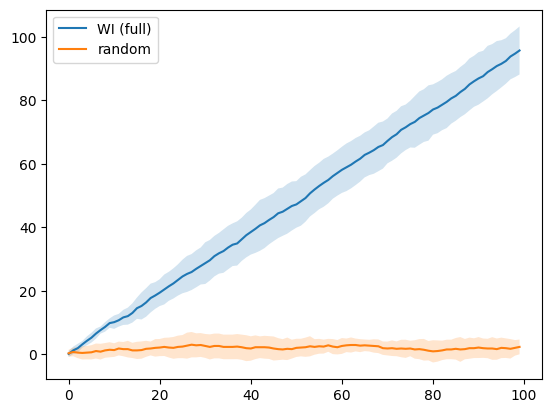

In [ ]:
data = [WI_reward, random_reward]
labels = ['WI (full)', 'random']

make_plot(data, labels)

## Assuming transition matrix is noisy to user.
We also assume true transition matrix stays the same throughout the game.

Experiment protocol:

1.   There is a ground truth transition matrix to each arm $i$ as $p_i(a, s, s')$ not visible to the user
2.   At the beginning of the game, a noisy $\hat{p}_i(a, s, s')$ is given to the user
3. The user believe $\hat{p}_i(a, s, s')$ is the correct transition dynamics, and will use this.

Generation of $\hat{p}_i(a, s, s')$:

first we know $\sum_{s'} \hat{p}_i(a, s, s') = 1, \forall a, s $, it make sense to pertubate the probability vector for a fixed $a, s$. For each arm:

*   Fix $a, s$, we have a probability vector $p_i(A=a, S=s, S)$
*   sample each cooidinate of vector $\epsilon$ from $N(0, \sigma)$.
*   $\hat{p}_i(A=a, S=s, S) \propto p_i(A=a, S=s, S) + \epsilon $
*   then we renormalize $\hat{p}_i$










In [ ]:
# pertubation variance:
sigma = 1e-1

noisy_WI_reward = list()

for i in range(n_trials):
    print('trail number:', i+1)

    # ground truth transition provided to bandit model
    # same parameters, initial start as above
    rb.reset()

    # noisy transitions used for WI computation
    perturbed_transitions = np.zeros_like(transitions)
    for n in range(n_arms):
        perturbed_transitions[n,:,:,:] = noisy_transitions(transitions[n], sigma)
    noisy_WI_reward.append(WI_train(rb, R, transitions = perturbed_transitions, episode = 100, K = K ))


trail number: 1
trail number: 2
trail number: 3
trail number: 4
trail number: 5
trail number: 6
trail number: 7
trail number: 8
trail number: 9
trail number: 10


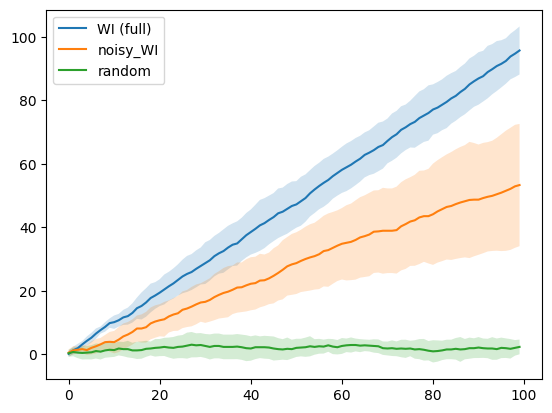

In [ ]:
data = [WI_reward, noisy_WI_reward, random_reward]
labels = ['WI (full)', 'noisy_WI', 'random']

make_plot(data, labels)

## Algo on 2 state transitions

*   2 state trasition, satisfy validity condition
*   simple reward. r(s = 0, a) = 0, r(s = 1, a) = 1
*   pull single arm
*   each arm may have different transition




In [ ]:
n_arms = 50
n_states = 2
n_transitions = 50
K = 1
R = np.array([0, 1])

transitions_indx = np.random.choice(n_transitions, size = n_arms)

transitions = np.zeros((n_arms, 2, n_states, n_states))

for i in range(n_transitions):
    transitions[transitions_indx == i] =  make_valid_transition(random_transitions(n_actions = 2, n_states = n_states))

init_states = np.zeros((n_arms, n_states))
indx = np.random.choice(n_states, size = n_arms)
init_states[np.arange(len(indx)), indx] = 1

rb = Restless_Bandit(transitions = transitions, initial_states = init_states, R = R)


In [ ]:
# run with multiple trials with the same initial, parameters
n_trials = 10
WI_reward = list()
random_reward = list()
exp3_reward = list()
UCB_reward = list()

for i in range(n_trials):
    print('trail number:', i+1)

    rb.reset()
    WI_reward.append(WI_train(rb, R, episode = 100, K = K ))

    rb.reset()
    random_reward.append(random_train(rb, episode = 100, K = K ))

    rb.reset()
    exp3_reward.append(Exp3_train(rb, R, episode=100, K=K))

    rb.reset()
    UCB_reward.append(UCB(rb, R, episode=100, K=K))



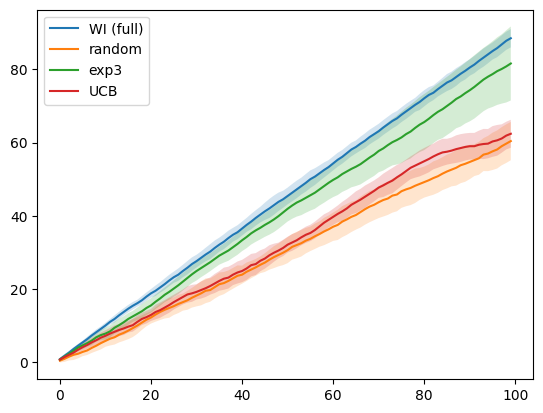

In [ ]:

data = [WI_reward, random_reward, exp3_reward, UCB_reward]
labels = ['WI (full)', 'random', 'exp3', 'UCB' ]

make_plot(data, labels)


## Linear Contextual Bandit.

*   2 states
*   pull 1 arm
*   Assume reward is a linear combination of some feature.

At $t$, for arm $i$ we have randomly generated features $x_{t,i}$. We assume reward $r_{t,i}$:

$$ E[r_{t,i} | x_{t, i} ] = \langle x_{t,i} , \theta^{\ast} \rangle$$

$\theta^{\ast}$ is unknown to the user



In [5]:
n_arms = 50
n_states = 2
n_transitions = 50
K = 1
R = np.array([0, 1])
n_dims = 10

transitions_indx = np.random.choice(n_transitions, size = n_arms)

transitions = np.zeros((n_arms, 2, n_states, n_states))

for i in range(n_transitions):
    transitions[transitions_indx == i] =  make_valid_transition(random_transitions(n_actions = 2, n_states = n_states))

init_states = np.zeros((n_arms, n_states))
indx = np.random.choice(n_states, size = n_arms)
init_states[np.arange(len(indx)), indx] = 1

rb = Restless_Bandit(transitions = transitions, initial_states = init_states, R = R)

In [10]:
import copy

T = 100
n_trials = 10
theta_star = random_features(n_dims, 1, scale = 1)
rb1 = copy.deepcopy(rb)
rb2 = copy.deepcopy(rb)
rb3 = copy.deepcopy(rb)

exp3 = contextual_exp3(rb1, theta_star, T, K = 1)
LinUCB = contextual_LinUCB(rb2, theta_star, K = 1)
random = contextual_random(rb3, theta_star, K = 1)

In [ ]:
exp3_rewards = list()
LinUCB_rewards = list()
random_rewards = list()

for i in range(n_trials):
    print('trail number:', i+1)
    exp3_reward = list()
    LinUCB_reward = list()
    random_reward = list()
    for t in range(T):
        partial_feature = random_features(n_arms, n_dims-1)
        exp3.step(partial_feature)
        LinUCB.step(partial_feature)
        random.step(partial_feature)
        exp3_reward.append(exp3.reward)
        LinUCB_reward.append(LinUCB.reward)
        random_reward.append(random.reward)

    exp3_rewards.append(exp3_reward)
    LinUCB_rewards.append(LinUCB_reward)
    random_rewards.append(random_reward)


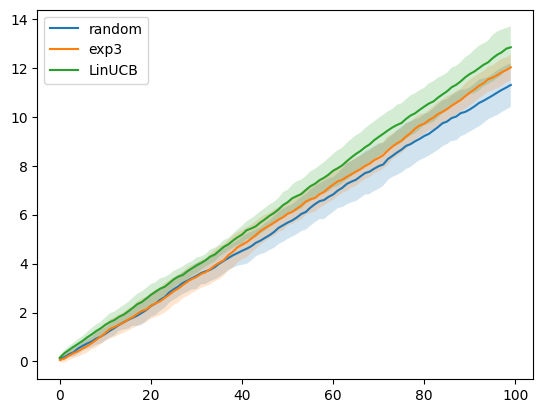

In [12]:
data = [random_rewards, exp3_rewards, LinUCB_rewards]
labels = ['random' , 'exp3', 'LinUCB' ]

make_plot(data, labels)

In [ ]:
T = 100
n_trials = 10
# theta_star = random_features(n_dims, 1, scale = 1)
theta_star = gaussian_features(n_dims, 1, scale = 1)
theta_star[-1] = abs(theta_star[-1]) # last feature is previous state,

rb1 = copy.deepcopy(rb)
rb2 = copy.deepcopy(rb)
rb3 = copy.deepcopy(rb)

exp3 = contextual_exp3(rb1, theta_star, T, K = 1)
LinUCB = contextual_LinUCB(rb2, theta_star, K = 1)
random = contextual_random(rb3, theta_star, K = 1)

exp3_rewards = list()
LinUCB_rewards = list()
random_rewards = list()

for i in range(n_trials):
    print('trail number:', i+1)
    exp3_reward = list()
    LinUCB_reward = list()
    random_reward = list()
    for t in range(T):
        partial_feature = random_features(n_arms, n_dims-1)
        exp3.step(partial_feature)
        LinUCB.step(partial_feature)
        random.step(partial_feature)
        exp3_reward.append(exp3.reward)
        LinUCB_reward.append(LinUCB.reward)
        random_reward.append(random.reward)

    exp3_rewards.append(exp3_reward)
    LinUCB_rewards.append(LinUCB_reward)
    random_rewards.append(random_reward)
data = [random_rewards, exp3_rewards, LinUCB_rewards]
labels = ['random' , 'exp3', 'LinUCB' ]


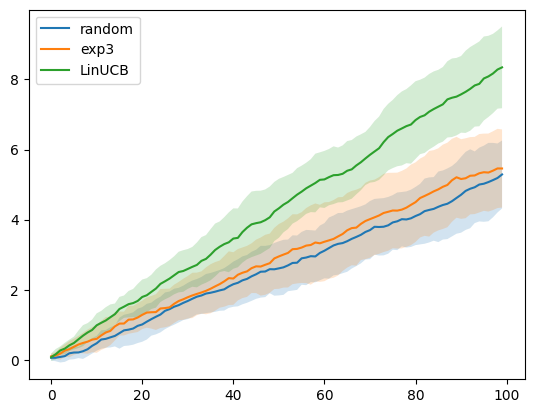

In [16]:
make_plot(data, labels)